<hr/>
# ** Feature Extraction and Fine Tuning using VGG16**
<span id="0"></span>
[**Tolgahan Çepel**](https://www.kaggle.com/tolgahancepel)
<hr/>
<font color=green>
1. [Overview](#1)
1. [Importing Libraries and Reading the Dataset](#2)
1. [Using a Pretrained Convnet](#3)
1. [Feature Extraction](#4)
    * [Feature Extraction without Data Augmentation](#5)
    * [Feature Extraction with Data Augmentation](#6)
1. [Fine Tuning](#7)    
1. [Conclusion](#8)

## <span id="1"></span> ** 1. Overview **
#### [Return Contents](#0)
I have built a convnet from scratch using this Flower Recognition dataset before. The accuracy was about %79-80. In this kernel, my passion is to get experience about transfer learning and compare results of each models. We know that using transfer learning in small datasets should improve accuracy. Let's see the difference!

You can view my <a href="https://www.kaggle.com/tolgahancepel/flower-recognition-convnet-from-scratch">Flower Recognition ConvNet from Scratch</a> kernel. The first part is completely same.

## <span id="2"></span> ** 2. Importing Libraries and Reading the Dataset **
#### [Return Contents](#0)
The images dataset are not seperated into training and test set. In this section, we are going to copy images and divide into two folder (train and validation). I have added detailed folder list that you can see later. But simply, the folder will bel like this:
```
data/
    train/
        category1/(contains all images related to category1)  
        category2/(contains all images related to category2)
        ...
        ...
            
    validation/
        category1/(contains all images related to category1)  
        category2/(contains all images related to category2)
        ...
        ...
```

In [1]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg
# plotly
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import tensorflow as tf
from plotly.graph_objs import *
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)
    
    plt.figure(figsize=(8,8))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [4]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

print(data_dir)

228818944/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets/flower_photos.tar


In [5]:
data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [6]:
# !ls -l /root/.keras/datasets/flower_photos
!rm -rf /kaggle/working/flowers-recognition
!mkdir -p /kaggle/working/flowers-recognition/flowers
!cp -r /root/.keras/datasets/flower_photos/* "/kaggle/working/flowers-recognition/flowers"
!rm -rf /kaggle/working/flowers-recognition/flowers/LICENSE.txt

!ls -l /kaggle/working/flowers-recognition/flowers

total 200
drwx------ 2 root root 36864 Nov 20 15:07 daisy
drwx------ 2 root root 53248 Nov 20 15:07 dandelion
drwx------ 2 root root 36864 Nov 20 15:07 roses
drwx------ 2 root root 40960 Nov 20 15:07 sunflowers
drwx------ 2 root root 36864 Nov 20 15:07 tulips


Original folder list is here as you can see below. But we need a training and test set. Let's get them.
```
/kaggle/input/flowers-recognition/
    flowers/
        tulip
        daisy
        sunflower
        rose
        dandelion
```

In [7]:
# original dataset folder, you can see above
input_path = Path('/kaggle/working/flowers-recognition')
flowers_path = input_path / 'flowers'

In [8]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'dandelion', 'tulips', 'roses', 'sunflowers']


In [9]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,/kaggle/working/flowers-recognition/flowers/da...
1,daisy,/kaggle/working/flowers-recognition/flowers/da...
2,daisy,/kaggle/working/flowers-recognition/flowers/da...
3,daisy,/kaggle/working/flowers-recognition/flowers/da...
4,daisy,/kaggle/working/flowers-recognition/flowers/da...


This cell above, creating a dataframe which contains all images and their path. If we run this command to see first row's image path:
```
>> flowers['image'][0]
```

The output:
```
'/kaggle/input/flowers-recognition/flowers/tulip/122450705_9885fff3c4_n.jpg'
```


In [10]:
# feel free to edit "0" (corresponds 0. image)
# flowers['image'][0]

In [11]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3670
Flowers in each category: 
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: category, dtype: int64


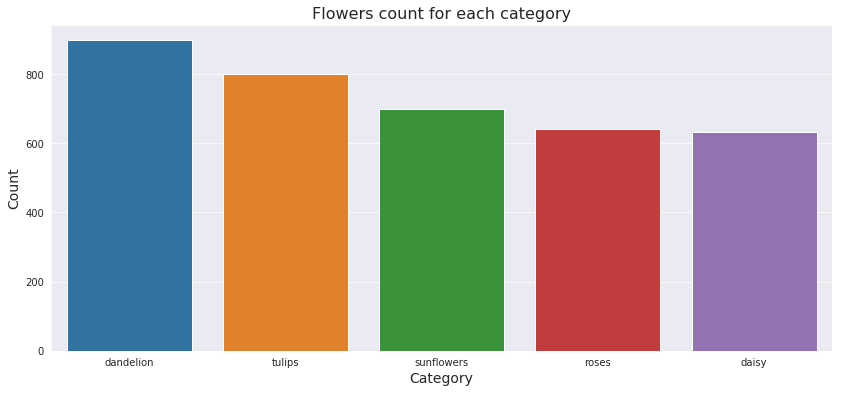

In [12]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = fl_count.index, y = fl_count.values, ax = axe)
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

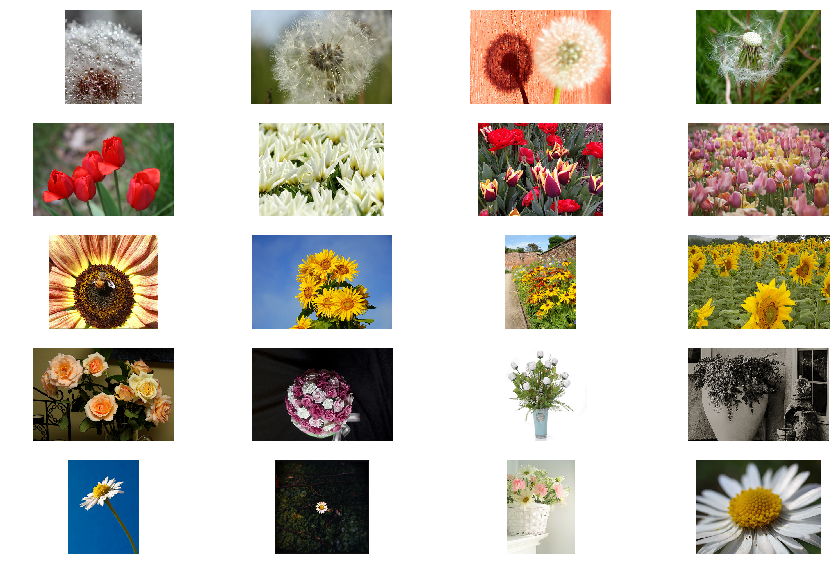

In [13]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

In [14]:
! rm -rf data/train data/valid

# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulips
%mkdir -p train/sunflowers
%mkdir -p train/roses
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulips
%mkdir -p valid/sunflowers
%mkdir -p valid/roses
%mkdir -p valid/dandelion

%cd ..

# You can verify that everything went correctly using ls command
!ls -ltrR data

/kaggle/working/data
/kaggle/working
data:
total 8
drwxr-xr-x 7 root root 4096 Nov 20 15:07 train
drwxr-xr-x 7 root root 4096 Nov 20 15:07 valid

data/train:
total 20
drwxr-xr-x 2 root root 4096 Nov 20 15:07 daisy
drwxr-xr-x 2 root root 4096 Nov 20 15:07 tulips
drwxr-xr-x 2 root root 4096 Nov 20 15:07 sunflowers
drwxr-xr-x 2 root root 4096 Nov 20 15:07 roses
drwxr-xr-x 2 root root 4096 Nov 20 15:07 dandelion

data/train/daisy:
total 0

data/train/tulips:
total 0

data/train/sunflowers:
total 0

data/train/roses:
total 0

data/train/dandelion:
total 0

data/valid:
total 20
drwxr-xr-x 2 root root 4096 Nov 20 15:07 daisy
drwxr-xr-x 2 root root 4096 Nov 20 15:07 tulips
drwxr-xr-x 2 root root 4096 Nov 20 15:07 sunflowers
drwxr-xr-x 2 root root 4096 Nov 20 15:07 roses
drwxr-xr-x 2 root root 4096 Nov 20 15:07 dandelion

data/valid/daisy:
total 0

data/valid/tulips:
total 0

data/valid/sunflowers:
total 0

data/valid/roses:
total 0

data/valid/dandelion:
total 0


Now, it's time to prepare our training and test sets. This code below copying files into new folders and creating new images stored like below.
```
data/
    train/
        daisy  
        dandelion
        rose
        sunflower
        tulip
            
    validation/
        daisy  
        dandelion
        rose
        sunflower
        tulip
```

In [15]:
!pwd

/kaggle/working


In [16]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    
    # Copy first 100 samples to the validation directory and rest to the train directory
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'/kaggle/working/data/valid/' + str(category) + '/'+ name)
        
    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'/kaggle/working/data/train/' + str(category) + '/' + name)

In [17]:
!ls -ltrR /kaggle/working/data/valid/tulips |head -10

/kaggle/working/data/valid/tulips:
total 6836
-rw-r--r-- 1 root root  27370 Nov 20 15:07 3474066174_8d3b3e8f97_n.jpg
-rw-r--r-- 1 root root  58173 Nov 20 15:07 8838914676_8ef4db7f50_n.jpg
-rw-r--r-- 1 root root  21342 Nov 20 15:07 8712268519_f4c2c39a06_n.jpg
-rw-r--r-- 1 root root  30537 Nov 20 15:07 6267021825_a8316e0dcc_m.jpg
-rw-r--r-- 1 root root 114939 Nov 20 15:07 4945315538_97bdd873c4.jpg
-rw-r--r-- 1 root root  27977 Nov 20 15:07 2229804138_db9cba3443_n.jpg
-rw-r--r-- 1 root root 120376 Nov 20 15:07 14087860553_bf4f8ec56d.jpg
-rw-r--r-- 1 root root  24404 Nov 20 15:07 13529687904_3d60abb479_n.jpg


If you are familiar with **cd** and **ls** commands, you can see new folders and image files by using them.

## <span id="3"></span> ** 3. Using a Pretrained Convnet **
#### [Return Contents](#0)
There are 2 ways to use a pretranied network: **Feature Extraction** and **Fine-Tuning**. In this kernel, we will use both techniques and compare their results. We will use VGG16 architecture which is developed by Karen Simonyan and Andrew Zisserman in 2014. You can read the paper here: <a href="https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a>

In [18]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [20]:
base_dir = '/kaggle/working/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

## <span id="4"></span> ** 4. Feature Extraction **
#### [Return Contents](#0)
We can extract features of our images dataset using a pretrained model. This is called Feature Extraction. There are 2 ways to use this method, first one doesn't support data augmentation, but however the second method is usable with data augmentation.

### <span id="5"></span> ** Feature Extraction without Data Augmentation **
#### [Return Contents](#0)
We will run our images on VGG16 convolutional base and get some 2d arrays. The output of this architecture will be features that extracted. And then, train these arrays with classic neural networks. However, data augmentation is not available for this method.

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

This function is extracting features on VGG16 convolutional base and returns (features, labels).

In [22]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count, 5))

    generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory,
        target_size=(240, 240),
        batch_size = batch_size, 
        class_mode='categorical')

    i = 0

    print('Entering for loop...');

    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [24]:
train_features, train_labels = extract_features(train_dir, 3170)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 3170 images belonging to 5 classes.
Entering for loop...
Found 500 images belonging to 5 classes.
Entering for loop...


In [26]:
train_features = np.reshape(train_features, (3170, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (500, 7 * 7 * 512))

In [27]:
model = models.Sequential()
model.add(layers.Dense(2048, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [30]:
history = model.fit(train_features, train_labels,
                    epochs=25,
                    batch_size=16,
                    validation_data=(validation_features, validation_labels))

Train on 3170 samples, validate on 500 samples
Epoch 1/25
3170/3170 [==============================] - 3s 1ms/step - loss: 1.7907 - acc: 0.3486 - val_loss: 1.2106 - val_acc: 0.4780
Epoch 2/25
3170/3170 [==============================] - 3s 995us/step - loss: 1.2588 - acc: 0.5060 - val_loss: 0.9381 - val_acc: 0.6540
Epoch 3/25
3170/3170 [==============================] - 3s 996us/step - loss: 1.0373 - acc: 0.6041 - val_loss: 0.7911 - val_acc: 0.7340
Epoch 4/25
3170/3170 [==============================] - 3s 1000us/step - loss: 0.8526 - acc: 0.6883 - val_loss: 0.7432 - val_acc: 0.7520
Epoch 5/25
3170/3170 [==============================] - 3s 995us/step - loss: 0.7419 - acc: 0.7363 - val_loss: 0.6685 - val_acc: 0.7820
Epoch 6/25
3170/3170 [==============================] - 3s 1ms/step - loss: 0.6513 - acc: 0.7789 - val_loss: 0.6891 - val_acc: 0.7540
Epoch 7/25
3170/3170 [==============================] - 3s 989us/step - loss: 0.5492 - acc: 0.8050 - val_loss: 0.7701 - val_acc: 0.7240
Epoc

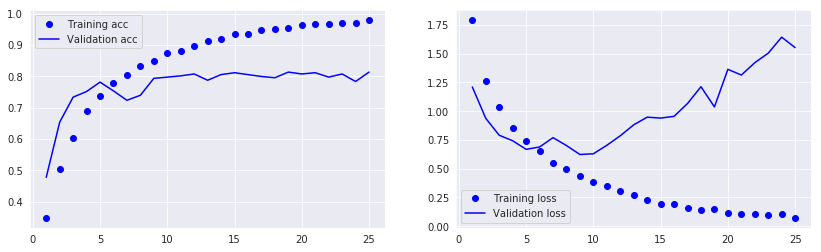

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [32]:
model_1_val = val_acc[-1]
print("Validation Accuracy: ", model_1_val)

Validation Accuracy:  0.8140000104904175


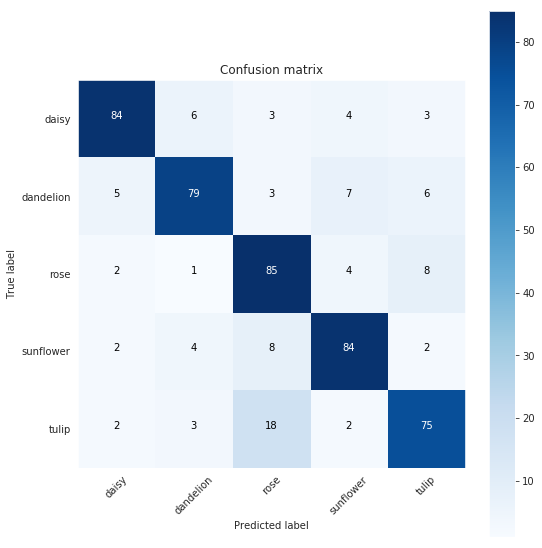

In [33]:
y_pred=model.predict_classes(validation_features)
con_mat = tf.math.confusion_matrix(validation_labels.argmax(1), y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(cm = con_mat, classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], normalize = False)

Even we use Dropout, the model has overfitting problem as you seen. The accuracy is almost same with "from scratch" model, about %80. However, using data augmentation is one of the ways to prevent overfitting. Let's try augmentation and see the improvement.

### <span id="6"></span> ** Feature Extraction with Data Augmentation **
#### [Return Contents](#0)
We can also use pretrained model by adding our Dense layers to end of convolutional base. This will allow us to use data augmentation. But however, it's slower than the first feature extraction method. But we hope that using data augmentation will prevent overfitting and improve the accuracy.

In [34]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [36]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 3170 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [38]:
# epoch = 15 arrive 90% accurancy, 20 should be enough

history = model.fit_generator(
          train_generator,
          epochs=30,
          validation_data=validation_generator)

Epoch 1/30
100/100 [==============================] - 45s 450ms/step - loss: 1.3719 - acc: 0.4221 - val_loss: 0.4055 - val_acc: 0.7100
Epoch 2/30
100/100 [==============================] - 44s 440ms/step - loss: 0.7506 - acc: 0.7151 - val_loss: 0.8186 - val_acc: 0.7980
Epoch 3/30
100/100 [==============================] - 43s 428ms/step - loss: 0.5163 - acc: 0.8091 - val_loss: 0.4519 - val_acc: 0.8640
Epoch 4/30
100/100 [==============================] - 43s 434ms/step - loss: 0.4735 - acc: 0.8319 - val_loss: 0.3677 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 44s 439ms/step - loss: 0.3670 - acc: 0.8621 - val_loss: 0.3147 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 44s 439ms/step - loss: 0.3382 - acc: 0.8789 - val_loss: 0.3368 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 43s 434ms/step - loss: 0.2947 - acc: 0.8909 - val_loss: 0.3702 - val_acc: 0.8940
Epoch 8/30
100/100 [==============================] - 4

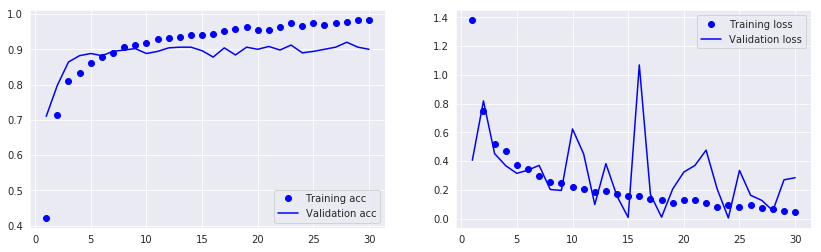

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [43]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

Validation Accuracy:  0.8999999761581421


The model is still overfitting, however the accuracy is pretty good!

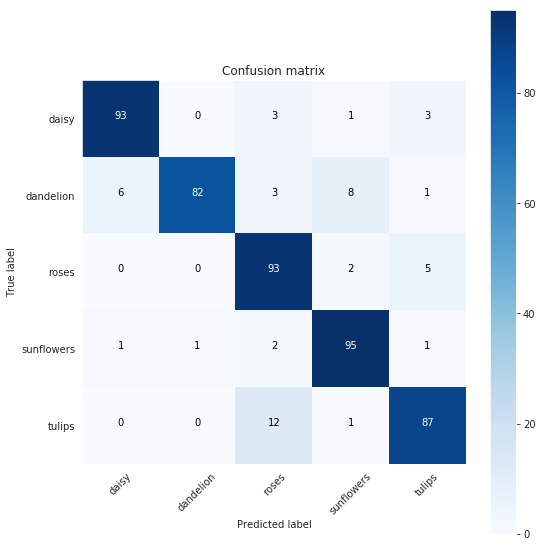

In [44]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(cm = con_mat, classes = validation_generator.class_indices.keys(), normalize = False)

## <span id="7"></span> ** 5. Fine Tuning **
#### [Return Contents](#0)

In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [47]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

In [49]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=6,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/6
100/100 [==============================] - 49s 488ms/step - loss: 0.0158 - acc: 0.9946 - val_loss: 0.2577 - val_acc: 0.9607
Epoch 2/6
100/100 [==============================] - 44s 441ms/step - loss: 0.0172 - acc: 0.9948 - val_loss: 0.2622 - val_acc: 0.9593
Epoch 3/6
100/100 [==============================] - 44s 442ms/step - loss: 0.0117 - acc: 0.9966 - val_loss: 0.0035 - val_acc: 0.9629
Epoch 4/6
100/100 [==============================] - 44s 443ms/step - loss: 0.0113 - acc: 0.9960 - val_loss: 0.1035 - val_acc: 0.9666
Epoch 5/6
100/100 [==============================] - 44s 444ms/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.1979 - val_acc: 0.9666
Epoch 6/6
100/100 [==============================] - 44s 441ms/step - loss: 0.0115 - acc: 0.9961 - val_loss: 0.1466 - val_acc: 0.9643


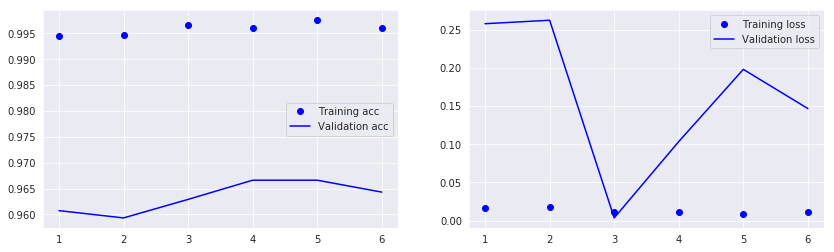

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [52]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.9643222689628601


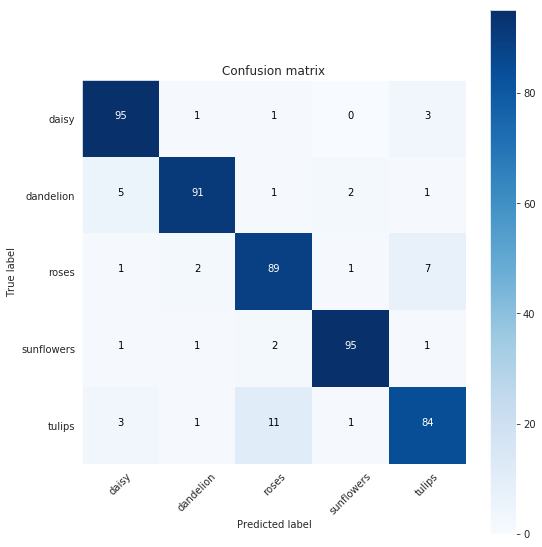

In [53]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(cm = con_mat, classes = validation_generator.class_indices.keys(), normalize = False)

In [ ]:
# deleting training and test sets, because kaggle is trying to show all
# images that we created as output
shutil.rmtree("/kaggle/working/data")

## <span id="8"></span> ** 6. Conclusion **
#### [Return Contents](#0)


In [ ]:
my_color = ['Gold','MediumTurquoise','LightGreen']
trace=go.Bar(
            x=['ConvNet from Scratch', 'Feature Extraction w/o DA', 'Feature Extraction w/ DA', 'Fine-Tuning'],
            y=[0.7937, round(model_1_val,4), round(model_2_val,4), round(model_3_val,4)],
            text=[0.7937, round(model_1_val,4), round(model_2_val,4), round(model_3_val,4)],
            textposition='auto',
            marker=dict(
                color=px.colors.sequential.deep,
                line=dict(
                color=px.colors.sequential.deep,
                width=0.4),
            ),
            opacity=1)

data = [trace]
layout = go.Layout(title = 'Accuracies of Models',
              xaxis = dict(title = 'Model'),
              yaxis = dict(title = 'Accuracy'))
fig = go.Figure(data = data, layout = layout)
iplot(fig)

I have tried to implement my convolutional neural networks knowledge in Keras. In the first kernel, built a model from scratch and get %80 accuracy. This is also good but, because the dataset is "small", transfer learning can give better results. You can see validation accuracies of the models. Please give me feedback for improvements. I am still learning.

<b><font color="red">Don't forget to </font></b> <b><font color="green">UPVOTE </font></b> if you liked this kernel, thank you. 🙂👍